## Notebook 4 - Evaluating our GOES cloud thresholding

To test how well the thresholding is working from GOES radiances/brightnesses, let's pull the pixel for Kettle Ponds and compare to observed radiative fluxes for the SAIL/SPLASH/SoS site.

#### Sections:
1 - Comparison to incoming shortwave from UW tower

2 - Comparison to total sky imager

3 - Try random forest to determine RGB thresholds

In [18]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Part 1

#### Load in in situ obs and processed GOES RGB composite

In [19]:
date = '20230605'

# In situ obs load
obs_path = '/storage/cdalden/goes/surface_obs/'
obs_file = f'isfs_sos_qc_geo_tiltcor_5min_v2_{date}.nc'
obs = xr.open_dataset(obs_path + obs_file)
# Convert the 'time' coordinate to a pandas.DatetimeIndex
obs['time'] = pd.to_datetime(obs['time'].values)

# Localize the time to UTC and convert to MDT
obs = obs.assign_coords(
    time=pd.to_datetime(obs['time'].values).tz_localize('UTC').tz_convert('America/Denver')
)

# GOES data load
goes_path = '/storage/cdalden/goes/goes16/rgb_composite/'
goes_file = f'goes16_C02_C05_C13_RGB_colorado_{date}.nc'

# Use f-string to dynamically name the dataset
goes_ds_name = f'goes_{date}'
globals()[goes_ds_name] = xr.open_dataset(goes_path + goes_file)

# Access the dataset
# goes_20230605


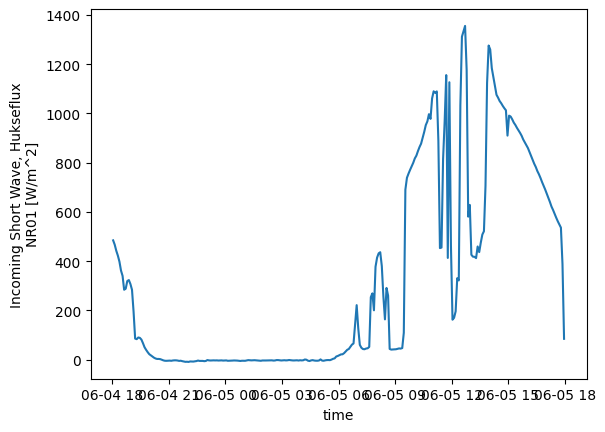

In [20]:
obs['Rsw_in_uw'].plot()

In [21]:
latitude = obs.latitude_uw.values
longitude = obs.longitude_uw.values
goes_crested_butte_pixel = globals()[goes_ds_name].sel(y=latitude, x=longitude, method='nearest')


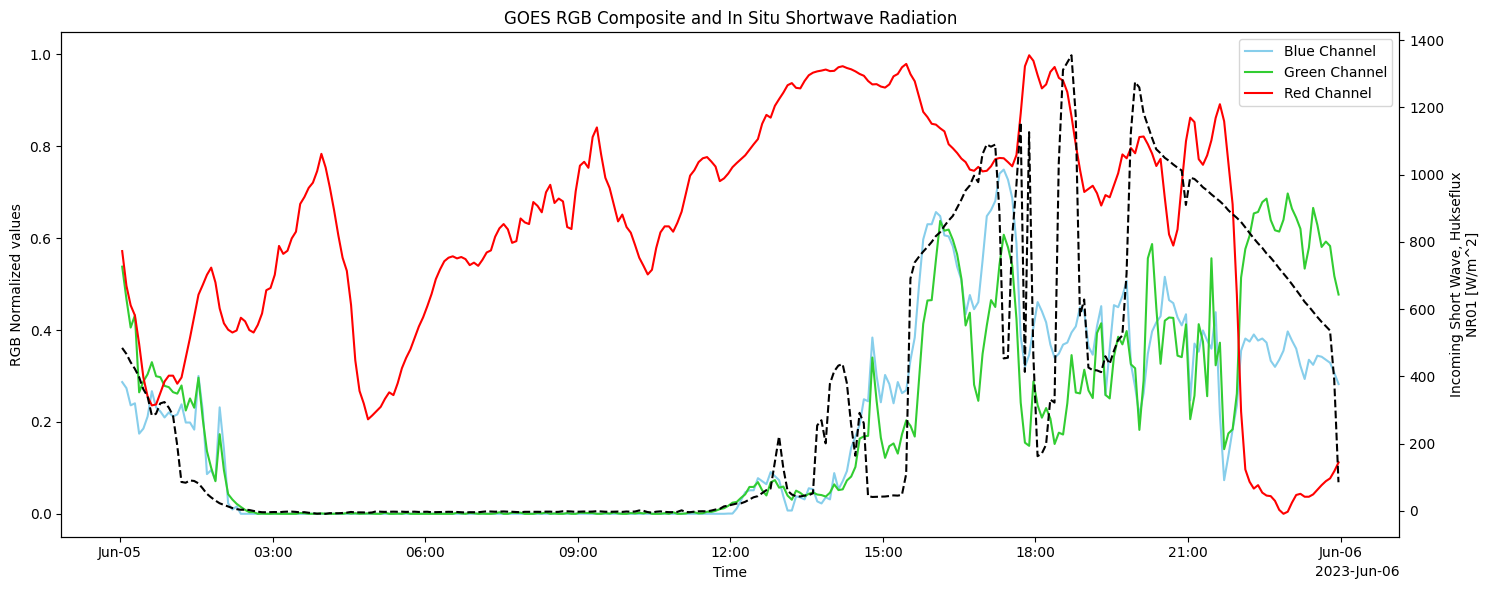

In [22]:
# Plot the GOES data for the specific pixel
fig, ax = plt.subplots(figsize=(15, 6))
goes_crested_butte_pixel['blue'].plot(ax=ax, label='Blue Channel', color='skyblue')
goes_crested_butte_pixel['green'].plot(ax=ax, label='Green Channel', color='limegreen')
goes_crested_butte_pixel['red'].plot(ax=ax, label='Red Channel', color='red')

ax2 = ax.twinx()
obs['Rsw_in_uw'].plot(ax=ax2, 
                             color='black', label='In Situ Shortwave In', ls = '--')


ax.set_xlabel('Time')
ax.set_ylabel('RGB Normalized values')
ax.set_title('GOES RGB Composite and In Situ Shortwave Radiation')
ax.legend()

plt.tight_layout()
plt.savefig(f'./plots/goes_rgb_kettle_ponds_comparison_{date}.png', dpi=300)

## Part 2
### Comparison to total sky imager

In [23]:
tsi_path = '/storage/cdalden/goes/surface_obs/total_sky_imager/'
tsi_file = f'guctsiskycoverM1.b1.{date}.000000.cdf'
tsi = xr.open_dataset(tsi_path + tsi_file)

In [24]:
tsi

<xarray.Dataset> Size: 372kB
Dimensions:                         (time: 1754)
Coordinates:
  * time                            (time) datetime64[ns] 14kB 2023-06-05 ......
Data variables: (12/52)
    base_time                       datetime64[ns] 8B ...
    time_offset                     (time) datetime64[ns] 14kB ...
    qc_time                         (time) int32 7kB ...
    percent_opaque                  (time) float32 7kB ...
    qc_percent_opaque               (time) int32 7kB ...
    percent_thin                    (time) float32 7kB ...
    ...                              ...
    qc_count_mask                   (time) int32 7kB ...
    count_sub_horz                  (time) float32 7kB ...
    qc_count_sub_horz               (time) int32 7kB ...
    lat                             float32 4B ...
    lon                             float32 4B ...
    alt                             float32 4B ...
Attributes: (12/69)
    command_line:                 tsi_ingest -s guc -f M1
    process_version:              ingest-tsi-12.8-5.el7
    dod_version:                  tsiskycover-b1-3.2
    site_id:                      guc
    facility_id:                  M1: Mt Crested Butte, Colorado
    data_level:                   b1
    ...                           ...
    qc_bit_2_description:         Value is less than the valid_min.
    qc_bit_2_assessment:          Bad
    qc_bit_3_description:         Value is greater than the valid_max.
    qc_bit_3_assessment:          Bad
    datastream:                   guctsiskycoverM1.b1
    history:                      created by user dsmgr on machine prod-proc2...

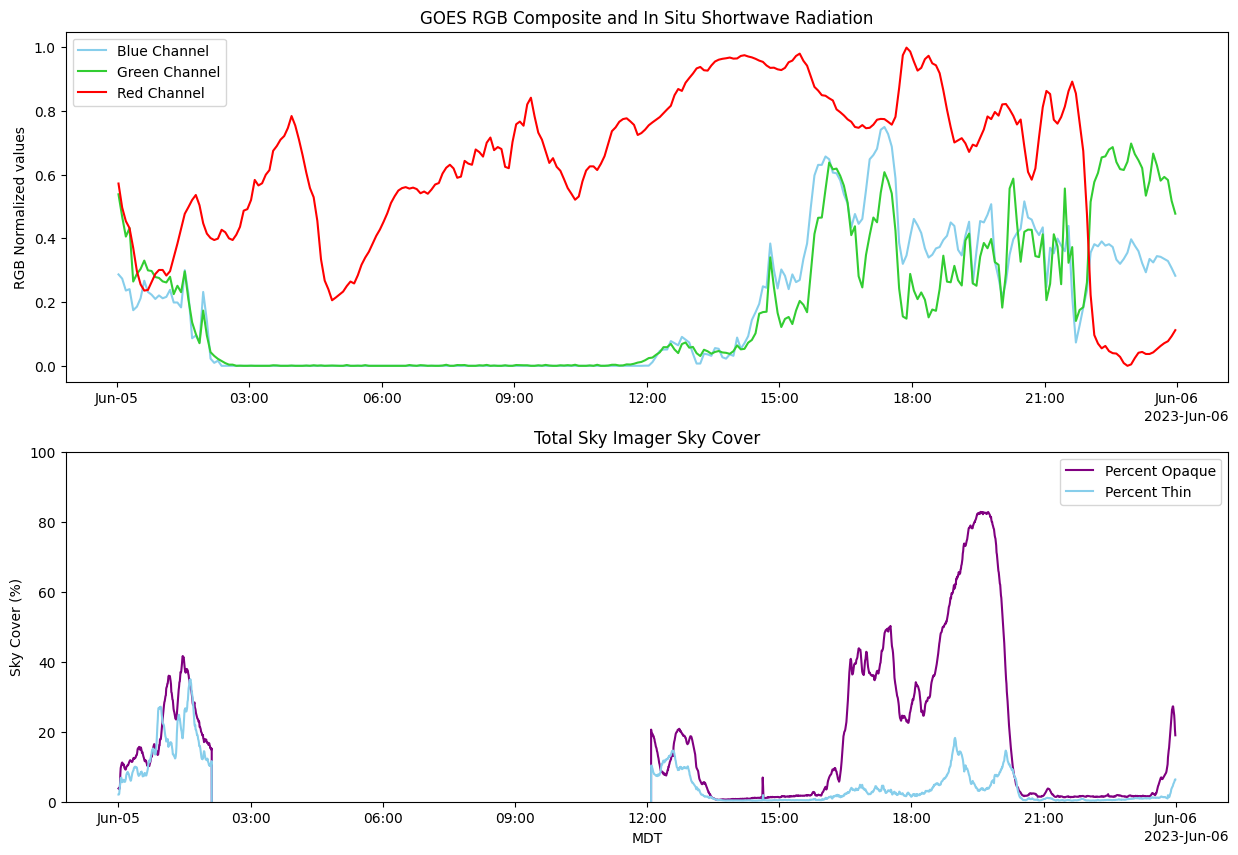

In [25]:
fig, ax = plt.subplots(2,1,figsize=(15, 10))

# Plot the GOES data for the specific pixel
goes_crested_butte_pixel['blue'].plot(ax=ax[0], label='Blue Channel', color='skyblue')
goes_crested_butte_pixel['green'].plot(ax=ax[0], label='Green Channel', color='limegreen')
goes_crested_butte_pixel['red'].plot(ax=ax[0], label='Red Channel', color='red')

ax[0].set_xlabel('')
ax[0].set_ylabel('RGB Normalized values')
ax[0].set_title('GOES RGB Composite and In Situ Shortwave Radiation')
# ax[0].set_xlim(pd.to_datetime('2023-06-05T12:00:00'), pd.to_datetime('2023-06-06T00:00:00'))
ax[0].legend()


# Plot the total sky imager data
tsi['percent_opaque'].plot(ax=ax[1], color='purple', label='Percent Opaque')
tsi['percent_thin'].plot(ax=ax[1], color='skyblue', label='Percent Thin')
# tsi['sunny'].plot(ax=ax[1], color='orange', label='Sunny') # this is just a binary sun/no sun class

ax[1].set_xlabel('MDT')
ax[1].set_ylabel('Sky Cover (%)')
ax[1].set_title('Total Sky Imager Sky Cover')
ax[1].set_ylim(0, 100)
ax[1].legend()

## Part 3
### Models to determine thresholds

## Part 3a
### Decision Trees - not that good

In [26]:
# Step 1: Extract the time coordinate
timestamps = tsi['time']

# Step 2: Filter timestamps at 5-minute intervals starting at 00:02:30
# and within the range 12:00 to 23:57:30
filtered_timestamps = timestamps.where(
    ((timestamps.dt.minute - 2) % 5 == 0) & 
    (timestamps.dt.second == 30) & 
    (timestamps.dt.hour >= 12) & 
    ((timestamps.dt.hour < 23) | ((timestamps.dt.hour == 23) & (timestamps.dt.minute <= 57))),
    drop=True
)

# Step 3: Create a new dataset with filtered timestamps
filtered_tsi = tsi.sel(time=filtered_timestamps)

# Replace values outside the range [0, 100] with NaN
filtered_tsi["percent_opaque"] = filtered_tsi.percent_opaque.where(
    (filtered_tsi.percent_opaque >= 0) & (filtered_tsi.percent_opaque <= 100)
)

# Perform linear interpolation to fill NaN values caused by filtering
filtered_tsi["percent_opaque"] = filtered_tsi.percent_opaque.interpolate_na(
    dim="time", method="linear"
)

# Check if any NaNs remain (e.g., at the edges) and fill them with a fallback value
filtered_tsi["percent_opaque"] = filtered_tsi.percent_opaque.fillna(0)  # Replace with a suitable fallback value if needed

In [27]:
filtered_goes = goes_crested_butte_pixel.sel(
    t=goes_crested_butte_pixel.t.where(
        goes_crested_butte_pixel.t.dt.hour >= 12, drop=True
    )
)

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ds = filtered_goes
# Step 1: Prepare the data
# Assuming `ds` is your dataset with 'red', 'blue', 'green', and `tsi['percent_opaque']` as `percent_opaque`
data = pd.DataFrame({
    'red': ds['red'].values,
    'blue': ds['blue'].values,
    'green': ds['green'].values,
    'percent_opaque': filtered_tsi['percent_opaque'].values
})

# Step 2: Split the data
X = data[['red', 'blue', 'green']]
y = data['percent_opaque']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train a Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=3, random_state=42)  # Limit depth for interpretability
regressor.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = regressor.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Step 5: Interpret the decision tree
from sklearn.tree import export_text
tree_rules = export_text(regressor, feature_names=['red', 'blue', 'green'])
print(tree_rules)

Mean Absolute Error (MAE): 14.544297094794063
Mean Squared Error (MSE): 376.54855911198683
R² Score: 0.3031201053705288
|--- blue <= 0.35
|   |--- red <= 0.85
|   |   |--- green <= 0.53
|   |   |   |--- value: [27.43]
|   |   |--- green >  0.53
|   |   |   |--- value: [3.33]
|   |--- red >  0.85
|   |   |--- blue <= 0.32
|   |   |   |--- value: [2.69]
|   |   |--- blue >  0.32
|   |   |   |--- value: [29.71]
|--- blue >  0.35
|   |--- green <= 0.42
|   |   |--- red <= 0.72
|   |   |   |--- value: [63.37]
|   |   |--- red >  0.72
|   |   |   |--- value: [26.74]
|   |--- green >  0.42
|   |   |--- blue <= 0.66
|   |   |   |--- value: [6.86]
|   |   |--- blue >  0.66
|   |   |   |--- value: [37.48]



## Part 3b
### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_regressor = RandomForestRegressor(n_estimators=500, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_regressor.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 13.148475003741003
Mean Squared Error (MSE): 330.6864503862961
R² Score: 0.38799728979427694


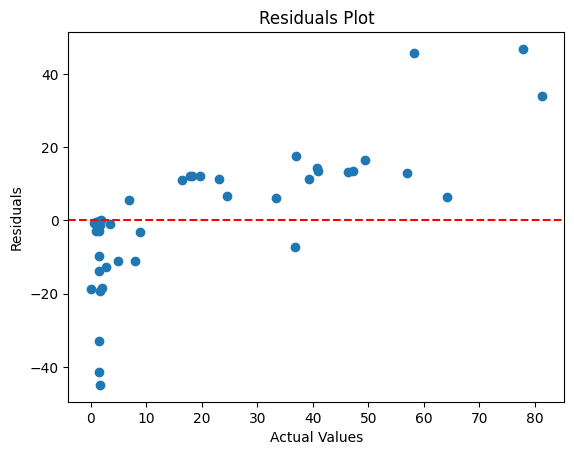

In [30]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()

#### Feature Importance

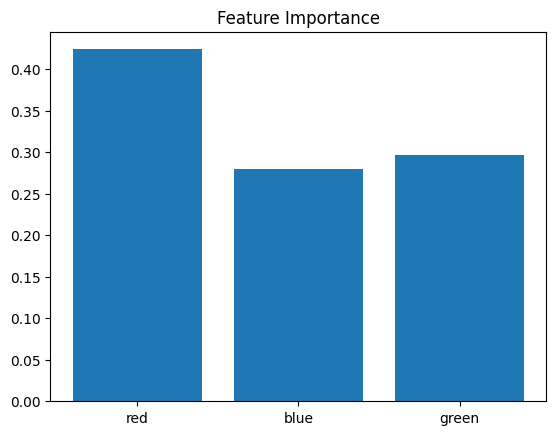

In [31]:
feature_importances = rf_regressor.feature_importances_
plt.bar(X.columns, feature_importances)
plt.title("Feature Importance")
plt.show()

## Part 3c

### Weighted Random Forest

Step 1  - Use a custom loss function

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight('balanced', y_train)

# Train Random Forest with sample weights
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train, sample_weight=sample_weights)

RandomForestRegressor(n_estimators=200, random_state=42)

Step 2 - Log transformation of the target

If the target variable is skewed, applying a log transformation can make the distribution more balanced and easier for the model to learn.

In [33]:

# Apply log transformation
y_train_log = np.log1p(y_train)

# Train the model
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train_log)

# Predict and reverse the transformation
y_pred_log = rf_regressor.predict(X_test)
y_pred = np.expm1(y_pred_log)

Step 3 - Upsample Minority Values

In [34]:
# from imblearn.over_sampling import SMOTENC

# smote = SMOTENC(categorical_features=[], random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # Train the model on the resampled data
# rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
# rf_regressor.fit(X_resampled, y_resampled)

Step 4 - Downsample Majority Values

In [35]:
# from sklearn.utils import resample

# # Combine X_train and y_train into a single DataFrame
# train_data = pd.concat([X_train, y_train], axis=1)

# # Separate majority and minority classes
# majority = train_data[train_data['percent_opaque'] == 0]
# minority = train_data[train_data['percent_opaque'] > 0]

# # Downsample majority class
# majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)

# # Combine minority and downsampled majority
# balanced_data = pd.concat([majority_downsampled, minority])

# # Split back into X and y
# X_train_balanced = balanced_data.drop('percent_opaque', axis=1)
# y_train_balanced = balanced_data['percent_opaque']

# # Train the model
# rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
# rf_regressor.fit(X_train_balanced, y_train_balanced)

## Part 3d

### Gradient Boosting - XGBoost

In [36]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 13.989335060119629
Mean Squared Error (MSE): 415.06573486328125
R² Score: 0.23183614015579224
